## Task 1
This notebook focuses on getting the given dataset ready for developing machine learning models through pre-processing and transformation. The top 10 most important features are identified using pearson correlation and then used to build an SVM classifier, which was then holistically evaluated.

<p style="font-style: italic;">Note - In each step, there were multiple methods of implementation that were tried hence, the addiditonal code for each section. For example: For normalisation, three different types were used for experimentation</p>

In [1]:
from ipynb.fs.full.functions import (
    fetch_datasets,
    find_non_unique_features, find_categorical_features, find_missing_values, find_data_types, plot_feature_split_of_values, plot_class_split_of_values,
    normalise_min_max, standardize_std_scaler, normalise_robust_scaler,
    save_dataset, load_model, save_model,
    calculate_variance_threshold, pearson_correlation, f_regression_scores, poisson_method,
    svc_classifier, find_best_configuration_svc,
    plot_correlation_heatmap, plot_predicted_vs_actual, plot_confusion_matrix, plot_det_curve, plot_roc_curve, plot_precision_recall_curve, plot_hyperparam_scores,
    fetch_classification_report, cross_val_score, add_data_to_json
)
import numpy as np
import matplotlib.pyplot as plt

In [2]:
x_train, x_test, y_train, y_test = fetch_datasets()
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(16200, 512)
(5400, 512)
(16200,)
(5400,)


-----------------------------------------------------------------
## Pre-Processing and Transformation

The pre-processing stage consisted of trying to find outliers in the train and test sets. Outliers were defined as features with no unique values or values that weren't numeric/missing. Thorugh analysis, it was found that no outliers exist hence why techniques like `Imputation` was not used as it is only relevant for handling missing values.

Visualisations were added to see the split of values and identify how data was spread out and whether there was a skew towards specific value. If there was a skew, the hypothesis was that this could be affecting the model's performance towards a specific class.

Conclusion - It can be seen that there are no outliers amongst the features and classes


Data types in x_train - {dtype('float64')} | Data types in x_test - {dtype('float64')}
Data types in y_train - float64 | Data types in y_test - float64
No features with 1 unique value in x_train
No features with 1 unique value in x_test
No categorical features in x_train
No categorical features in x_test
x_train has the following missing values - 0 | x_test has the following missing values - 0
y_train has the following missing values - 0 | y_test has the following missing values - 0


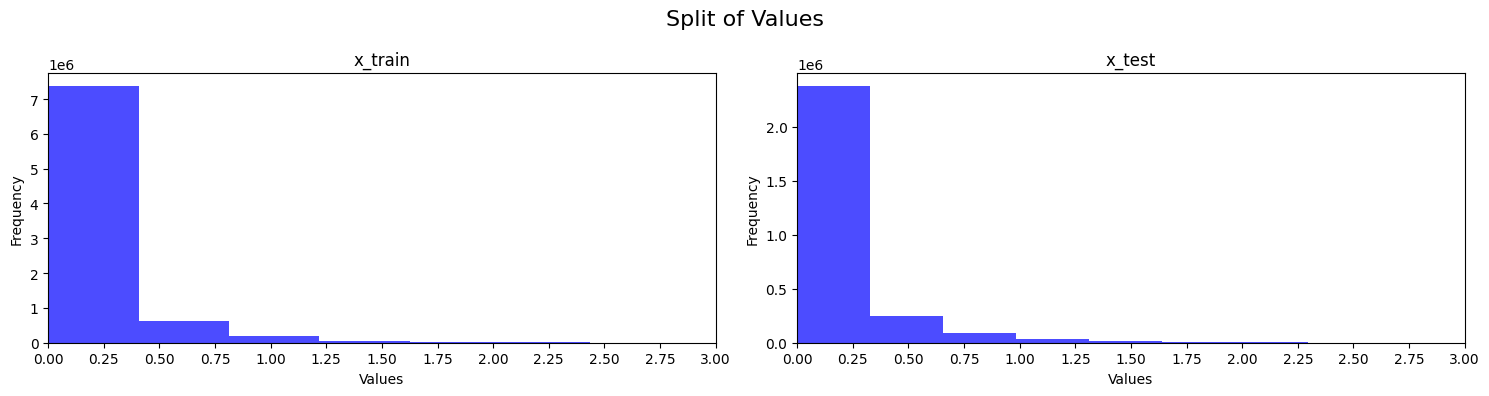

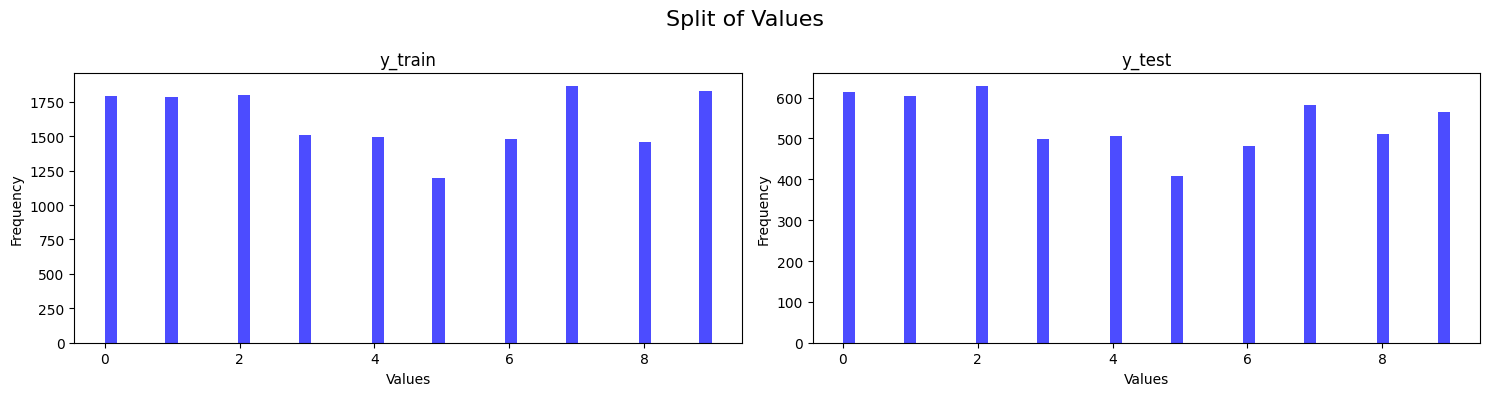

In [3]:
'''
Try different techniques of pre processing and transformation and see the difference in results?
'''
print(f"Data types in x_train - {find_data_types(x_train)} | Data types in x_test - {find_data_types(x_test)}")
print(f"Data types in y_train - {y_train.dtype} | Data types in y_test - {y_test.dtype}")

find_non_unique_features(x_train, "x_train")
find_non_unique_features(x_test, "x_test")

categorical_features_x_train = find_categorical_features(x_train, "x_train")
categorical_features_x_test = find_categorical_features(x_test, "x_test")

print(f"x_train has the following missing values - {find_missing_values(x_train)} | x_test has the following missing values - {find_missing_values(x_test)}")
print(f"y_train has the following missing values - {find_missing_values(y_train)} | y_test has the following missing values - {find_missing_values(y_test)}")

plot_feature_split_of_values([x_train, x_test], ["x_train", "x_test"])
plot_class_split_of_values([y_train, y_test], ["y_train", "y_test"])

-----------------------------------------------------------------
## Normalisation

As seen from the split of data above, the feature train and test datasets had a range between 0 and 2.5. To ensure features were on a similar scale, normalisation was used. Multiple types of scaling was experimented with - (i) Min Max, (ii) Standardisation, and (iii) Robust Scaler. The hypotheses tested with each is mentioned below.

1. <b>MinMax</b> - Scales the data to a fixed range (in this case, [-1, 1]) [1]. As no outliers were detected, this is typically used to linearly scale the features down to a defined range and presented the best testing accuracy.

2. <b>StandardScaler <span style="color: darkgreen;">[Best Performance]</span></b> - Scales the data based on the mean and standard deviation, so that each have values of 0 and 1 respectively. Although the performance was similar to MinMax, StandardScaler was chosen as it performed better on unseen data

3. <b>RobustScaler</b> - RobustScaler scales the data based on statistics and percentiles, protecting it against outliers unlike the above two methods [3]. Since there were no outliers in this dataset, it was not needed.

<span style="font-style: italic;">PS: Would not use MinMax or StandardScaler if outliers were detected as it is very sensitive to the presence of outliers</span>

datasets/saved_datasets/task1/x_train has the new dataset!
datasets/saved_datasets/task1/x_test has the new dataset!
datasets/saved_datasets/task1/y_train has the new dataset!
datasets/saved_datasets/task1/y_test has the new dataset!


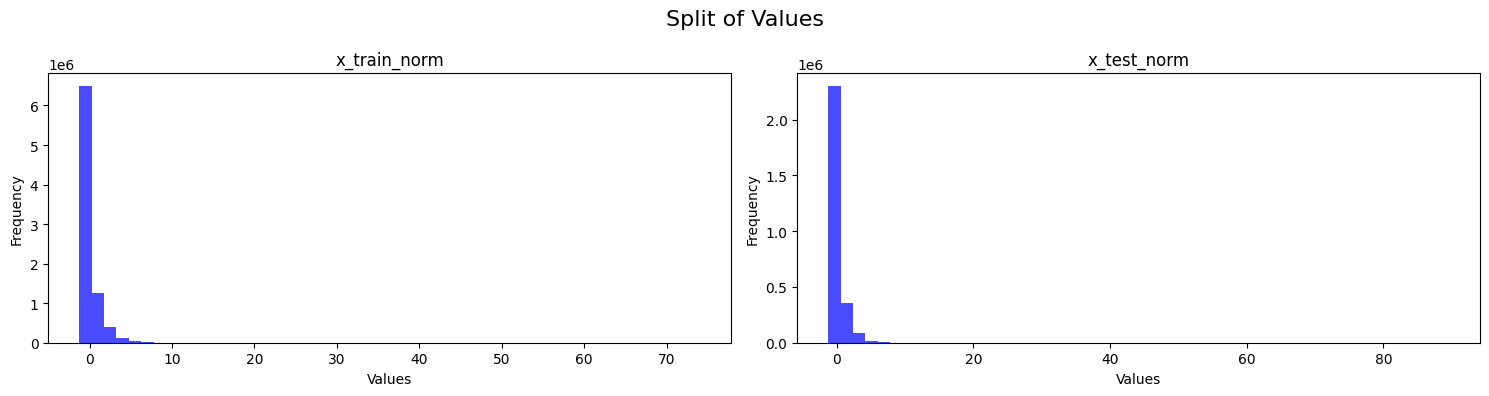

In [4]:
# ------- TRANSFORMATION ---------
# x_train_norm, x_test_norm = normalise_min_max(x_train, x_test) # Best configuration - Training Accuracy: 0.610246913580247 | Testing Accuracy: 0.5769753086419753
x_train_norm, x_test_norm = standardize_std_scaler(x_train, x_test) # Best configuration - Training Accuracy: 0.6041975308641976 | Testing Accuracy: 0.5772222222222222
# x_train_norm, x_test_norm = normalise_robust_scaler(x_train, x_test) # Best configuration - Training Accuracy: 0.5701234567901234 | Testing Accuracy: 0.5364814814814814

save_dataset(x_train_norm, "datasets/saved_datasets/task1/x_train")
save_dataset(x_test_norm, "datasets/saved_datasets/task1/x_test")
save_dataset(y_train, "datasets/saved_datasets/task1/y_train")
save_dataset(y_test, "datasets/saved_datasets/task1/y_test")

# Split of values after normalisation
plot_class_split_of_values([x_train_norm, x_test_norm], ["x_train_norm", "x_test_norm"])

## Feature Selection

This section goes over the feature selection processs of getting the top 10 features using Pearson correlation. The features of this set are all numerical as these are the extracted features from the input images. Due to this, it was assumed that the features did not consist of any order (Ordinal).

The aim of this section was to evaluate different methods/concepts of feature selection and evaluate the best model performance.

---------

> Method 1 - Variance threshold to remove redundant features and fetching the top 10 features (without Pearson Correlation)

The motivation behind trying variance threshold was to identify and remove redundant features as this was something that was not accounted for with Pearson Correlation.

<b>Conclusion - The top 10 features retrieved through this method were significantly different than any other method. This was expected as it is based on variance calculations whereas pearson correlation is based on the linear relationship between features</b>

Top 10 features after variance threshold -> [121 474 127 319 505 152 232 476 424  72]


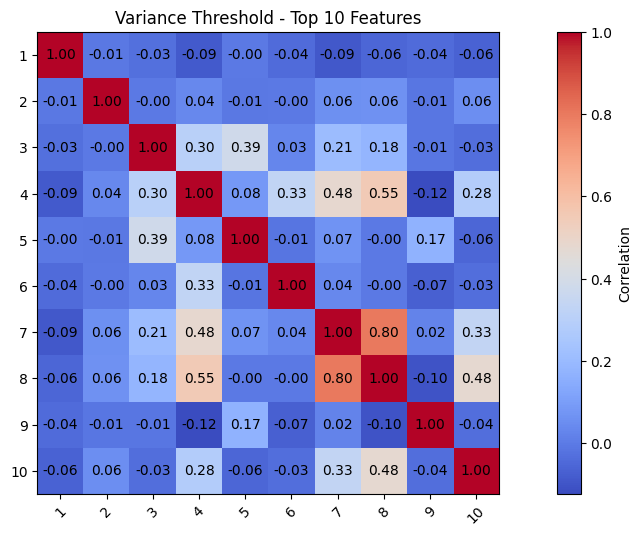

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
x_train_10_features_vthresh, x_test_10_features_vthresh = calculate_variance_threshold(x_train_norm, x_test_norm, True)
print(f"Top 10 features after variance threshold -> {x_train_10_features_vthresh}")
correlation_matrix = np.corrcoef(x_train_norm[:, x_train_10_features_vthresh].T, y_train)
plot_correlation_heatmap(ax, correlation_matrix, 'Variance Threshold - Top 10 Features')

As seen in the correlation matrix, there are multiple highly correlated features that are being selected that can be redundant, thus giving an early incling that the model's performance will suffer.

> Method 2 - Comparing the top 10 features using Pearson Correlation and Variance Threshold

To ensure the features had a linear relationship with the target variable, both `r_regression` and `f_regression` were used. Whilst `r_regression` follows the task requirements and retrieves the Pearson correlation coefficient to calculate the top 10 features, it is heavily used to quantify the strength of linear relationships between individual features and target variable. 

`f_regression` was used to evaluate the overall significance of each feature in explaining the variance in the target variable. Due to the high number of features, `f_regression` can be more efficient than `r_regression` because it considers the joint effect of all features on the target variable.

<b>Conclusion - after evaluating both methods, the top 10 features were the same. This concluded that the features exhibited linear relationships with the target variable, with both functions capturing the linear association similarly.</b>

The top 10 features before variance threshold are -> [178 479 136 369 254 440  38 485 116  64]
The top 10 features for f_reg before variance threshold are -> [178 479 136 369 254 440  38 485 116  64]
The top 10 features are -> [ 92  16  60  34  52  24 216  70 212 252]
The top 10 features f_reg are -> [ 92  16  60  34  52  24 216  70 212 252]


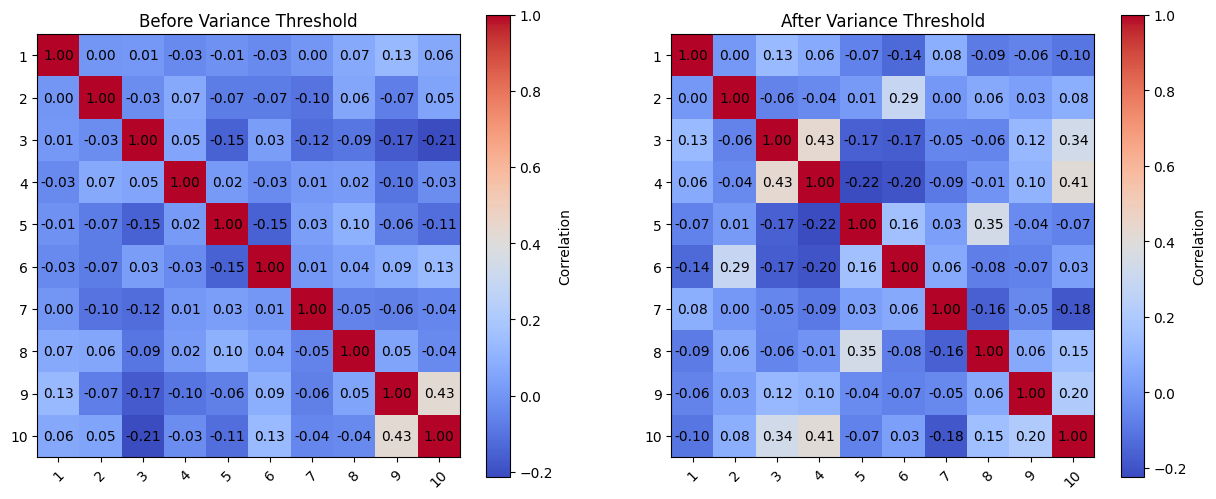

In [6]:
x_train_selected, x_test_selected = calculate_variance_threshold(x_train_norm, x_test_norm, False)
feature_correlation_pre = pearson_correlation(x_train_norm, y_train)
feature_correlation_f_reg_pre = f_regression_scores(x_train_norm, y_train)
feature_correlation = pearson_correlation(x_train_selected, y_train)
feature_correlation_f_reg = f_regression_scores(x_train_selected, y_train)

print(f"The top 10 features before variance threshold are -> {feature_correlation_pre[:10]}")
print(f"The top 10 features for f_reg before variance threshold are -> {feature_correlation_f_reg_pre[:10]}")
print(f"The top 10 features are -> {feature_correlation[:10]}")
print(f"The top 10 features f_reg are -> {feature_correlation_f_reg[:10]}")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# pre variance threshold (w/ Pearson Correlation)
top_features_indices = feature_correlation_pre[:10]
selected_features = x_train_norm[:, top_features_indices]
correlation_matrix_pre = np.corrcoef(selected_features.T, y_train)
plot_correlation_heatmap(axes[0], correlation_matrix_pre, 'Before Variance Threshold')

# Post variance threshold (w/ Pearson Correlation)
top_features_indices = feature_correlation[:10]
selected_features = x_train_selected[:, top_features_indices]
correlation_matrix = np.corrcoef(selected_features.T, y_train)
plot_correlation_heatmap(axes[1], correlation_matrix, 'After Variance Threshold')

Correlation heatmaps were used to evaluate the significance of the relationships between features. The hypotheses was that after performing variance threshold and removing the redundant features, (i) There would be weaker correlation between other features (darker colors on the heatmap), and the (ii) model accuracy would improve. As seen above, the heatmap disproves the first hypothesis as there are more surrounding features that have higher correlation before implemnting variance threshold which is not ideal but this was chosen as the best approach in the end, as it displayed the best training and testing accuracy with each being `0.610` and `0.578` respectively. 

> Method 3 - Comparing the performance of the model by training under features selected using the Poisson Method

The Poisson method was used to get the coefficient of each feature and rank the top 10 features, leveraging its ability to handle count data which is essential for the features of a multi-class dataset. This approach contrasts with the previous methods, as Poisson focuses on count-based feature selection.

Top 10 features after poisson method -> [400 444 232 202 405 355 381 389 504 183]


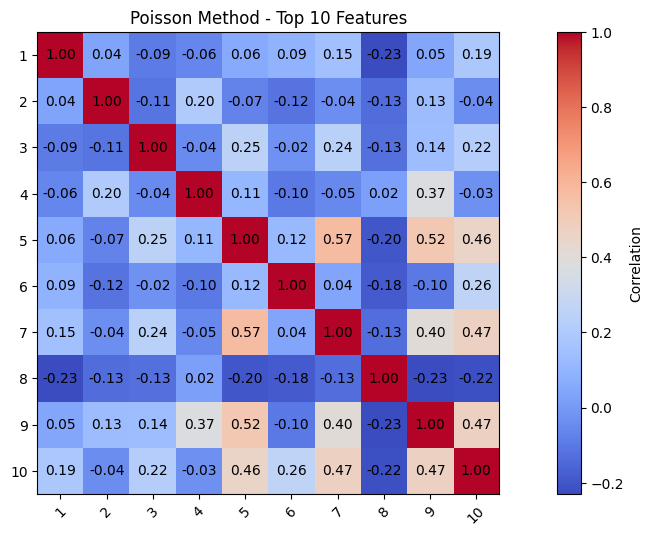

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
top_10_features_poisson = poisson_method(x_train_norm, y_train)
print(f"Top 10 features after poisson method -> {top_10_features_poisson}")
correlation_matrix = np.corrcoef(x_train_norm[:, top_10_features_poisson].T, y_train)
plot_correlation_heatmap(ax, correlation_matrix, 'Poisson Method - Top 10 Features')

-----------------------------------------------------------------
## Hyperparameter Optimisation
Mention tried different params to increase margin between train test accuracy, increasing accuracy but risking overfitting
The parameters that were manually tested were (what did you want to test?):

1. <b>c -</b> This is the regularisation parameter, representing the penalty for misclassification of outputs.

2. <b>kernel -</b> <b style="color: orange;">[add here]</b>

3. <b>gamma -</b> <b style="color: orange;">[add here]</b>

The best configuration was with the parameters -> 
Train accuracy -> <b style="color: orange;">[add here]</b>, Test accuracy -> <b style="color: orange;">[add here]</b>

<b>Note - Running the code below will take approximately 2 hours to finish execution</b>

In [24]:
parameters = {
    "c_values": [0.1, 1, 10, 50],
    "kernels_values": ["linear", "rbf", "poly", "sigmoid"],
    "gamma_values": ["scale", "auto", 0.01, 0.1]
}
best_config = find_best_configuration_svc(parameters, x_train_selected[:, feature_correlation[:10]], x_test_selected[:, feature_correlation[:10]], y_train, y_test, "task1")
print(best_config)

plot_hyperparam_scores(best_config["scores"])

-----------------------------------------------------------------
## Training and Validation

In this section, the model is trained with the dataset's top 10 features which was calculated using Pearson Correlation. The results were then validated using the following methods mentioned below:

1. Holdout Validation - Training the model using the testing set and evaluating it using the validation set

2. Cross Validation - Splits the model into 10 folds by default, trains and validated on each and presents a more reliable model performance

3. K-fold Cross Validation - Similar to CV, but tested with 20 folds to see if there is a difference in accuracy

4. Stratified K-fold Validation - Similar to CV, but was used as it ensures the same percentage of samples for each class are preserved [4].

<b>Support Vector Classification (SVC) is used over Support Vector Regression (SVR) in this coursework as the dataset is used for image classification</b>

In [17]:
# Comparing variance threshold top 10 features without pearson correlation
print("******** Results of variance threshold top 10 features ********")
svc_results_v_thresh = svc_classifier(x_train_norm[:, x_train_10_features_vthresh], x_test_norm[:, x_test_10_features_vthresh], y_train, y_test)

# Comparing variance threshold to remove redundant features + pearson correlation for top 10 features
print("******** Results of variance threshold + pearson correlation top 10 features ********")
svc_results_pearson = svc_classifier(x_train_selected[:, feature_correlation[:10]], x_test_selected[:, feature_correlation[:10]], y_train, y_test)

# Comparing features selected by Poisson method
print("******** Results of poisson method ********")
svc_results_poisson = svc_classifier(x_train_norm[:, top_10_features_poisson], x_test_norm[:, top_10_features_poisson], y_train, y_test)

******** Results of variance threshold top 10 features ********
------ Holdout Validation ------
Training Accuracy: 0.3923456790123457
Testing Accuracy: 0.14407407407407408
------ Cross Validation ------
Mean Accuracy: 0.38203703703703706
------ Stratified K fold Validation ------
Mean Accuracy: 0.38567901234567903
Std Deviation: 0.006999031003979434
******** Results of variance threshold + pearson correlation top 10 features ********
------ Holdout Validation ------
Training Accuracy: 0.6041975308641976
Testing Accuracy: 0.5766666666666667
------ Cross Validation ------
Mean Accuracy: 0.5765432098765432
------ Stratified K fold Validation ------
Mean Accuracy: 0.5771604938271604
Std Deviation: 0.014878976287893773
******** Results of poisson method ********
------ Holdout Validation ------
Training Accuracy: 0.6151234567901235
Testing Accuracy: 0.5990740740740741
------ Cross Validation ------
Mean Accuracy: 0.5987037037037037
------ Stratified K fold Validation ------
Mean Accuracy: 

In [19]:
save_model(svc_results_v_thresh, "models/task1/svc_results_vthresh") 
save_model(svc_results_pearson, "models/task1/svc_results")
save_model(svc_results_poisson, "models/task1/svc_results_possion") 

models/task1/svc_results_vthresh has the new model!
models/task1/svc_results has the new model!
models/task1/svc_results_possion has the new model!


In [22]:
svc_results_v_thresh = load_model("./models/task1/svc_results_vthresh")
svc_results_pearson = load_model("./models/task1/svc_results")
svc_results_poisson = load_model("./models/task1/svc_results_possion")

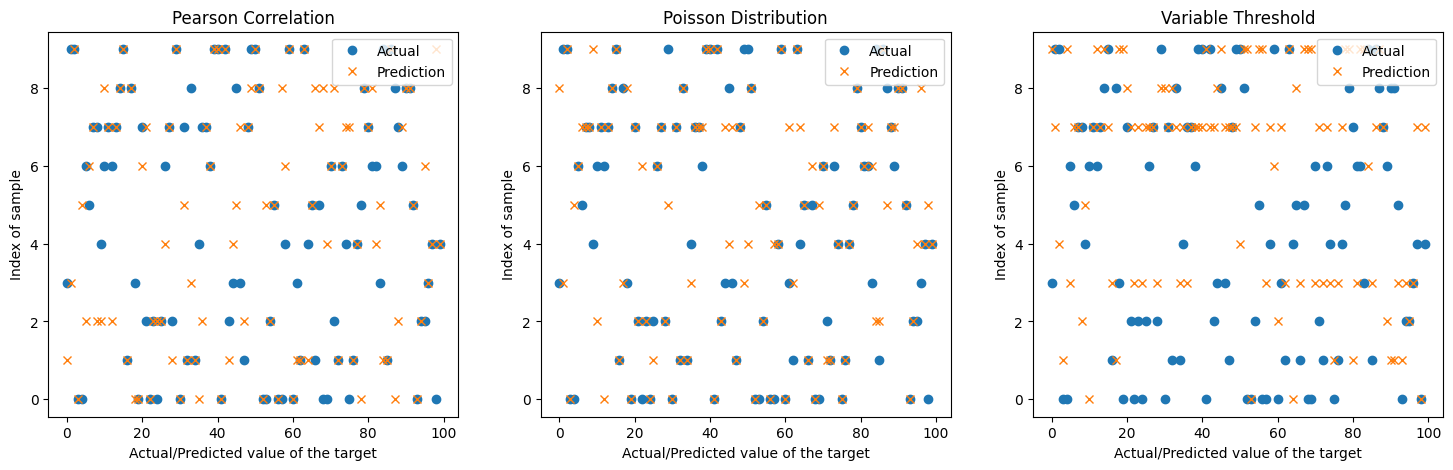

In [23]:
# y_preds = [y_pred_pearson, y_pred_poisson, y_pred_v_thresh]
# plot_predicted_vs_actual_subfigures(plot_titles, y_test, y_preds)
# plot_titles = ["Pearson Correlation", "Poisson Distribution", "Variable Threshold"]

y_pred_pearson = svc_results_pearson.predict(x_test_selected[:, feature_correlation[:10]])
y_pred_poisson = svc_results_poisson.predict(x_test_norm[:, top_10_features_poisson])
y_pred_v_thresh = svc_results_v_thresh.predict(x_test_norm[:, x_test_10_features_vthresh])
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
y_pred = svc_results_pearson.predict_proba(x_test_selected[:, top_features_indices])
plot_predicted_vs_actual(y_test, y_pred_pearson, "Pearson Correlation", axes[0], 100)
plot_predicted_vs_actual(y_test, y_pred_poisson, "Poisson Distribution", axes[1], 100)
plot_predicted_vs_actual(y_test, y_pred_v_thresh, "Variable Threshold", axes[2], 100)

As seen in the model performance, the best accuracy was SVC trained with Poisson method features selected - with training and testing accuracy fetching `0.662` and `0.649` respectively. 

<b>Due to the task's initial aim - the SVC trained with Pearson correlation was used going forward.</b>

-----------------------------------------------------------------
## Evaluation <b style="color: blue;">Define metric used for evaluation</b>
This section goes over the performance of the model, how and it what areas it could be improved, and metrics used to track this

#### Classification Report
The classification report is used to evaluate the performance of a classification model, specifically needed to see the split of the classes and the accuracy of predictions. The split of classes is valuable as there is a slight imbalance in the amount of samples per class.
The goal of seeing this is confirming the hypothesis that the accuracy of the model is low because of either (i) the imbalance in samples per classes and (ii) the number of features being used for training not being enough, with the report focusing on the former.

In [24]:
fetch_classification_report(svc_results_pearson, x_test_selected[:, top_features_indices], y_test)

----- Classification Report -----
              precision    recall  f1-score   support

         0.0       0.59      0.63      0.61       613
         1.0       0.64      0.69      0.67       605
         2.0       0.49      0.48      0.49       628
         3.0       0.46      0.26      0.33       499
         4.0       0.62      0.75      0.68       507
         5.0       0.49      0.51      0.50       409
         6.0       0.36      0.26      0.30       481
         7.0       0.64      0.73      0.68       583
         8.0       0.56      0.55      0.56       511
         9.0       0.71      0.81      0.75       564

    accuracy                           0.58      5400
   macro avg       0.56      0.57      0.56      5400
weighted avg       0.56      0.58      0.56      5400



Observations
- classes with low samples have the worst precision (TP success prediction) and recall (rate of predicting all TP) -> <b>Lowest 6 f1-score, 5 were the lowest amount of samples (except for class 2.0)</b>
- worst performance is within classes 2.0 - 6.0, with recall averaging 0.39 -> <b>indicating that model projects majority of the true occurences as false</b>

Conclusion - The imbalance in the dataset does seem to affect the accuracy of classes, with accuracy varying throughout

-----

Continuing from the the last section, the second assumption had to be validated. To do so, the model was trained with more features (taken 50 as a random amount). Immediately, what was visible is that the train and test accuracy reached `0.922` and `0.866` respectively.

<b>This concludes thathe model's accuracy being low is directly correlated to the number of features it is trained on</b>

In [25]:
svc_classifier(x_train_selected[:, feature_correlation[:50]], x_test_selected[:, feature_correlation[:50]], y_train, y_test)
save_model(svc_results_pearson, "models/task1/svc_results_feature_test")

------ Holdout Validation ------
Training Accuracy: 0.9118518518518518
Testing Accuracy: 0.8361111111111111
------ Cross Validation ------
Mean Accuracy: 0.8404320987654319
------ Stratified K fold Validation ------
Mean Accuracy: 0.8425308641975308
Std Deviation: 0.00562677261270222
models/task1/svc_results_feature_test has the new model!


#### Confusion Matrix
A confusion matrix was needed to evaluate the true against the predicted results for each class. In doing so, it will help retrieve and evaluate the `True Positive`, `True Negative`, `False Positive`, and `False Negative` for each class.

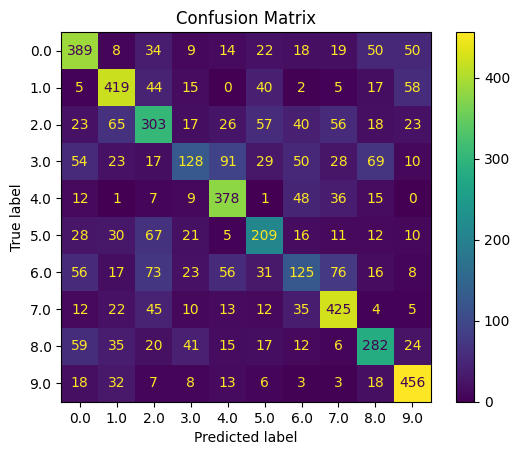

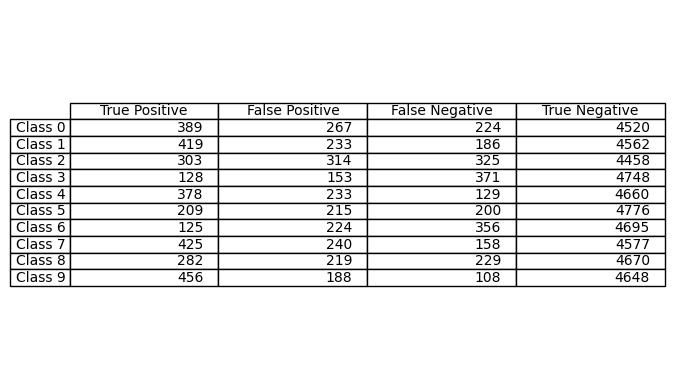

In [26]:
plot_confusion_matrix(svc_results_pearson, x_test_selected[:, top_features_indices], y_test, True)

#### Precision-Recall, ROC, and DET Curve

1. <b>Precision-Recall Curve -</b> Measures the trade-off between precision (`TP/(TP+FP)`) and recall (`TP/(TP+FN)`) for each class.

2. <b>Receiver Operating Curve -</b> Measures the comparison between the True Positive and False Positive for each class

3. <b>Detection Error Tradeoff Curve -</b> Measures the comparison between the False Positive and False Negative for each class

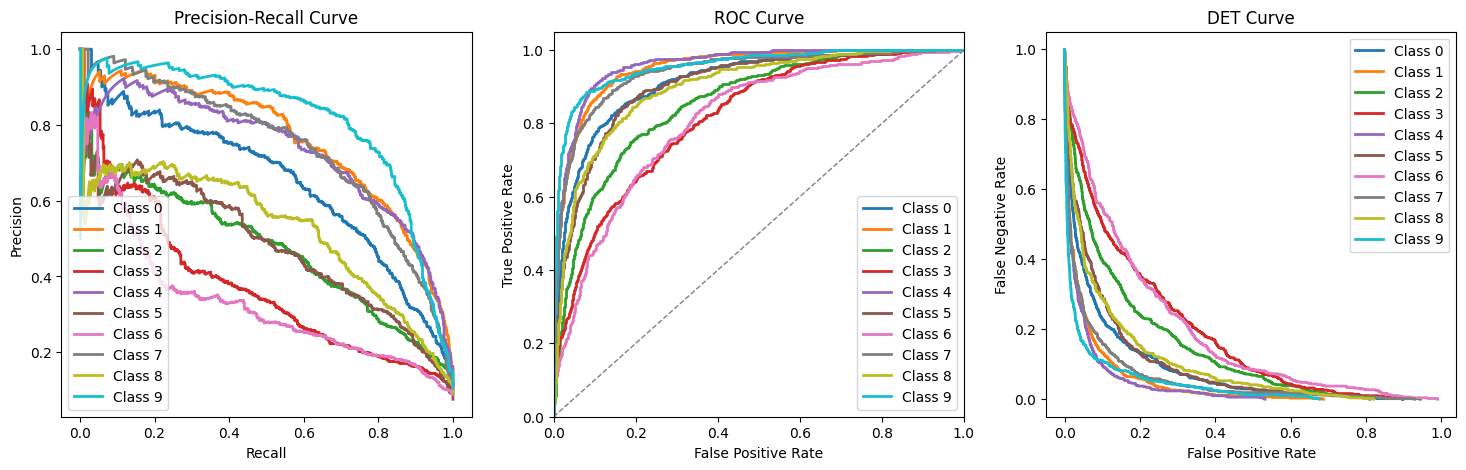

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
y_pred = svc_results_pearson.predict_proba(x_test_selected[:, top_features_indices])
plot_precision_recall_curve(y_test, y_pred, axes[0])
plot_roc_curve(y_test, y_pred, axes[1])
plot_det_curve(y_test, y_pred, axes[2])

#### Classification Metrics (?) -> Do I need? Maybe check classification papers online?

#### Logistic Regression?

<span style="font-weight: bold;">Markdown Question:</span> The difficulty in using pearson correlation method for feature selection is determining the appropriate number of features to select. The method described in the module to automatically choose> the appropriate number of features will be computationally very expensive when the number of features is high. Describe an alternative method to reduce the computational complexity of the method discussed in class for datasets with large number of features.

<span style="font-weight: bold;">Answer:</span> A combination of a heuristic search algorithm like Sequential Forward Search (SFS) and a ranking algorithm can be used to reduce computational complexity. SFS is a wrapper-based algorithm that selects the best features starting from 0. It chooses the best feature to add in each step based on the cross-validation score of the estimator and keeps incrementally adding features to find the right amount. To alleviate the computation risk with SFS when using a high number of features, pre-ranking should be performed so that SFS is performed on the most relevant and non-redundant feature set. This would reduce the number of steps and computational complexity to find the appropriate features.

Alongside the approach, best practices such as early stopping and parallelisation should also be implemented to ensure computationally intensive tasks are performed only when necessary and without using the load of a single machine.

- https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html

## References

[1] https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

[2] https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

[3] https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html

[4] https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html